In [10]:
from functools import reduce
import numpy as np
import random
from math import sin, cos
from numpy import average, mean
import matplotlib.pyplot as plt
from itertools import chain, combinations
from scipy.optimize import least_squares

In [11]:
def powerset(iterable, f):
    s = list(iterable)
    return list(chain.from_iterable(combinations(s, r) for r in range(f+1)))

In [12]:
def laplace_mechanismListAVG(data, powersets, k, sensitivity, epsilon, i, ns, last, propNoise=3):
    if k < last//propNoise:
        noise = (lambda x: (x if ns[i]<= 0  else -x)) (epsilon*np.random.normal(0,sensitivity))
    else:
        noise = -ns[i]
    ns[i] += noise   
    for el in powersets:
        data[el][-1] += noise

In [13]:
def build_dob_st(adj, dscrd):
    L = [[-adj[i][j]*(i not in dscrd and j not in dscrd) for j in range(len(adj))] for i in range(len(adj))]
    d = 1
    for i in range(len(L)):
        tmp = -sum(L[i])+1
        L[i][i] = tmp
        d = d if d > tmp else tmp
    for i in range(len(L)):
        for j in range(len(L)):
            L[i][j] = (i == j)*(d+1)/d - L[i][j]/d
    for i in dscrd:
        L[i][i] = 0
    return L

In [34]:
def select_state(w, v, pow_set, f, eps_comp):
    for i in range(1, f+1):
        aux = list(filter(lambda x:len(x) == i, pow_set))
        k = len(list(filter(lambda x:len(x) < i, pow_set)))
        if i == 1 and all(map(lambda x:abs(w[x][-1]-w[()][-1]) > eps_comp, aux[:v]+aux[v+1:])):
            return w[()][-1]     
        for j,y in enumerate(aux):
            if v not in y:
                if all(map(lambda x:abs(w[x][-1]-w[y][-1]) > eps_comp, \
                           pow_set[k:k+j]+pow_set[k+j+1:])):
                    return w[y][-1]
    return w[()][-1]  

In [35]:
def generalAVG(x0, adjacency_matrix, epsilon, max_iterations, f=0, attck=[], attck_vals={}, eps_comp=.01, propNoise=3):
    n = len(x0)
    ns = [0]*n
    powersets = powerset(range(n),f)
    adjs = {el: build_dob_st(adjacency_matrix, el) for el in powersets}
    aux = [{el:[x0[i]] for el in powersets} for i in range(n)]
    
    # PRIVACY
    for j in range(n):
        laplace_mechanismListAVG(aux[j], powersets, 0, 1, epsilon, j, ns, max_iterations, propNoise)
    
    r = [[el[()][-1] for el in aux]]
    if attck != []:
        for j in attck:
            for el in powersets:
                aux[j][el] = [attck_vals[j](0)]
            r[-1][j] = attck_vals[j](0)
    for i in range(1,max_iterations):
        r += [[]]
        for j in range(n):
            if j not in attck:
                for el in powersets:
                    aux[j][el] += [aux[j][()][i-1]] if sum(adjs[el][j]) < 10**(-10) \
                                else [sum([aux[v][el][i-1]*adjs[el][j][v] for v in range(n)])]
                    
                # PRIVACY
                laplace_mechanismListAVG(aux[j], powersets, i+1, 1, epsilon, j, ns, max_iterations, propNoise)    
                    
                    
                # ROBUSTNESS
                r[-1] += [select_state(aux[j], j, powersets, f, eps_comp)]
            else:
                for el in powersets:
                    aux[j][el] += [attck_vals[j](i)]
                r[-1] += [attck_vals[j](i)]
    return aux, r

In [36]:
x0 = [.1,.3,.7,.8]
adjacency_matrix = [[0,1,1,0],[1,0,0,1],[1,0,0,1],[0,1,1,0]]
epsilon = .1
max_iterations = 30

In [37]:
x0[:3]

[0.1, 0.3, 0.7]

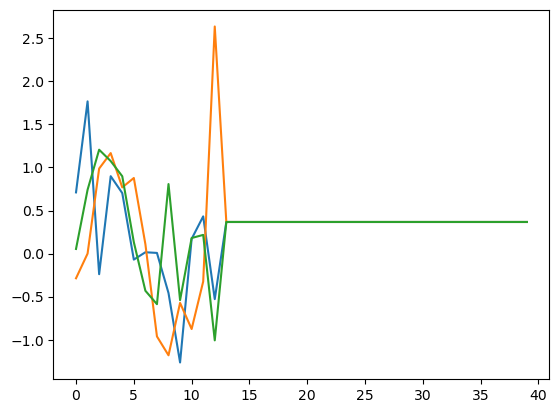

In [38]:
res,escolha=generalAVG(x0[:3],[[0,1,1],[1,0,1],[1,1,0]],.7,40,f=1,attck=[],attck_vals={},eps_comp=.01)
plt.plot(list(range(len(escolha))),list(escolha))
plt.show()

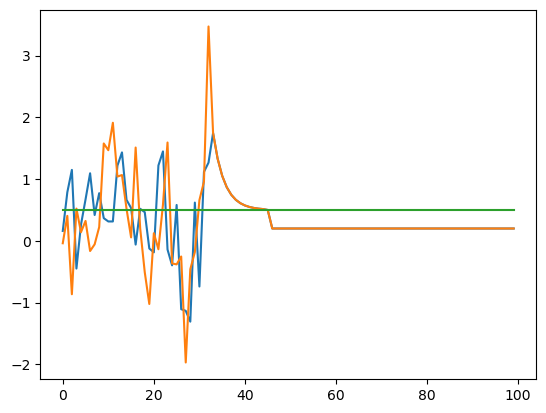

In [40]:
res,escolha=generalAVG(x0[:3],[[0,1,1],[1,0,1],[1,1,0]],.7,100,f=1,attck=[2],attck_vals={2:(lambda x:0.5)})
plt.plot(list(range(len(escolha))),list(escolha))
plt.show()

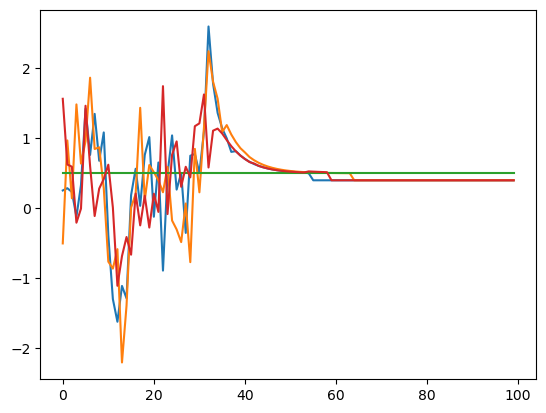

In [47]:
res,escolha=generalAVG(x0,adjacency_matrix,.7,100,f=1,attck=[2],attck_vals={2:(lambda x:0.5)})
plt.plot(list(range(len(escolha))),list(escolha))
plt.show()

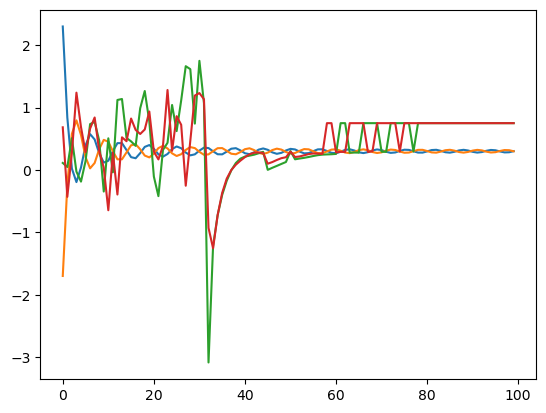

In [48]:
res,escolha=generalAVG(x0,adjacency_matrix,.5,100,f=2,attck=[0,1],attck_vals={0:(lambda x:0.3+cos(x)*2/(x+1)),\
                                                                            1:(lambda x:0.3-cos(x)*2/(x+1))})
plt.plot(list(range(len(escolha))),list(escolha))
plt.show()

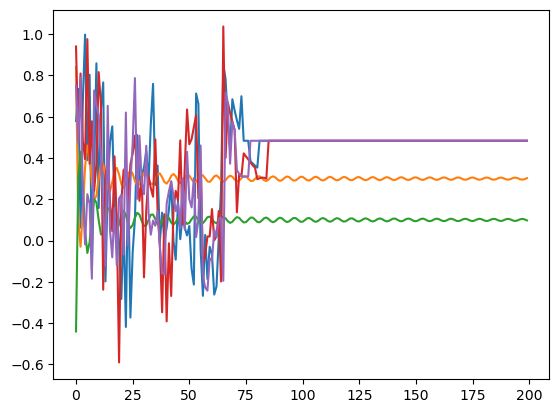

In [49]:
res,escolha=generalAVG(x0+[.55],[[0, 0, 1, 1, 1], [0, 0, 1, 1, 1], [1, 1, 0, 1, 1], \
                                 [1, 1, 1, 0,1],[1, 1, 1, 1, 0]],.2,200,f=2,attck=[1,2],\
                                   attck_vals={1:(lambda x:0.3+cos(x+1)/(x+1)),\
                                                2:(lambda x:0.1-cos(x+1)/(x+1))}, eps_comp=.05)
plt.plot(list(range(len(escolha))),list(escolha))
plt.show()

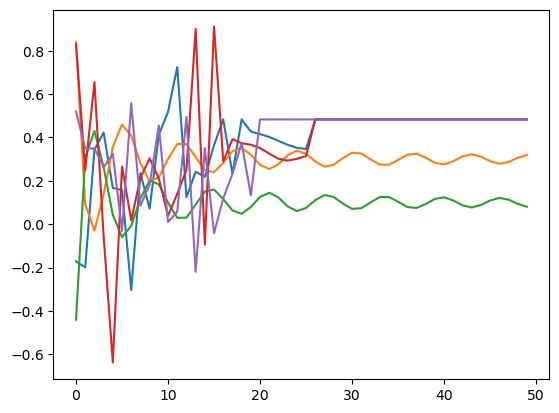

In [50]:
res,escolha=generalAVG(x0+[.55],[[0, 0, 1, 1, 1], [0, 0, 1, 1, 1], [1, 1, 0, 1, 1], \
                                 [1, 1, 1, 0,1],[1, 1, 1, 1, 0]],.2,50,f=2,attck=[1,2],\
                                   attck_vals={1:(lambda x:0.3+cos(x+1)/(x+1)),\
                                                2:(lambda x:0.1-cos(x+1)/(x+1))}, eps_comp=.05)
plt.plot(list(range(len(escolha))),list(escolha))
plt.show()

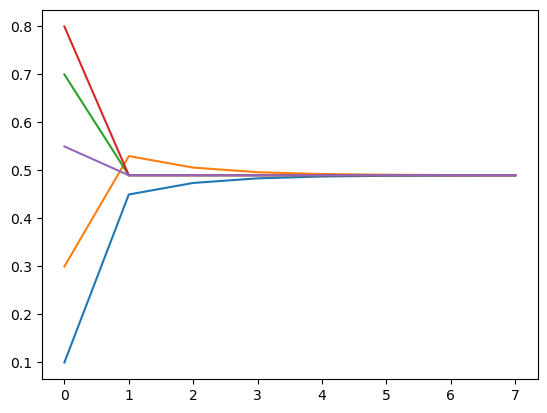

In [53]:
res,escolha=generalAVG(x0+[.55],[[0, 0, 1, 1, 1], [0, 0, 1, 1, 1], [1, 1, 0, 1, 1], \
                                 [1, 1, 1, 0,1],[1, 1, 1, 1, 0]],0,8,f=2,attck=[],\
                                   attck_vals={}, eps_comp=.005)
plt.plot(list(range(len(escolha))),list(escolha))
plt.show()

In [ ]:
tmp1 = [el[()] for el in res]


# Define the dynamical matrix A
A = np.array([[1/3, 1/3, 1/3],
              [1/3, 1/3, 1/3],
              [1/3, 1/3, 1/3]])

# Define the input matrix B (if applicable)
B = np.array([[0],
              [0],
              [0]])

# Define the observation matrix C
C = np.array([[1, 0, 0],
              [0, 1, 0],
              [0, 0, 1]])

# Define the observed measurements (replace with your actual data)
y = np.array(list(map(list,list(zip(*tmp1)))))

# Define the function to minimize (residuals)
def residuals(x0, y, A, C):
    # Extract initial state estimate from x0
    x0 = x0.reshape(-1, 1)
    
    # Predicted observations based on initial state estimate
    y_pred = [np.dot(C, x0)]
    for i in range(1, len(y)):
        y_pred.append(np.dot(C, np.dot(A, y_pred[-1])))
    
    # Compute residuals
    residuals = []
    for i in range(len(y)):
        residuals.extend(y[i] - y_pred[i].flatten())
    
    return residuals

# Initial guess for the initial state (replace with your initial estimate)
x0_initial_guess = np.array([0, 0, 0])

# Perform least squares estimation
result = least_squares(residuals, x0_initial_guess, args=(y, A, C))

# Estimated initial state
x0_estimated = result.x

print("Estimated initial state:", x0_estimated)

In [ ]:
class KalmanFilter:
    def __init__(self, A, C, Q, R):
        self.A = A  # Dynamical matrix
        self.C = C  # Observation matrix
        self.Q = Q  # Process noise covariance matrix
        self.R = R  # Measurement noise covariance matrix
        self.x_hat = None  # Estimated state
        self.P = None      # Estimated state covariance

    def initialize(self, x_hat_initial, P_initial):
        self.x_hat = x_hat_initial
        self.P = P_initial

    def predict(self):
        # Predict the next state
        self.x_hat = np.dot(self.A, self.x_hat)
        self.P = np.dot(np.dot(self.A, self.P), self.A.T) + self.Q

    def update(self, y):
        # Compute Kalman gain
        K = np.dot(np.dot(self.P, self.C.T), np.linalg.inv(np.dot(np.dot(self.C, self.P), self.C.T) + self.R))

        # Update estimated state and covariance
        self.x_hat = self.x_hat + np.dot(K, y - np.dot(self.C, self.x_hat))
        self.P = self.P - np.dot(np.dot(K, self.C), self.P)

# Define the dynamical matrix A
A = np.array([[1/3, 1/3, 1/3],
              [1/3, 1/3, 1/3],
              [1/3, 1/3, 1/3]])

# Define the input matrix B (if applicable)
B = np.array([[0],
              [0],
              [0]])

# Define the observation matrix C
C = np.array([[1, 0, 0],
              [0, 1, 0],
              [0, 0, 1]])

# Define the process noise covariance matrix Q
Q = np.eye(3) * 0.1

# Define the measurement noise covariance matrix R
R = np.eye(3) * 0.1

# Define the observed measurements (replace with your actual data)
y = np.array(list(map(list,list(zip(*tmp1)))))

# Initialize Kalman filter
kf = KalmanFilter(A=A, C=C, Q=Q, R=R)

# Initialize initial state estimate and covariance (replace with your initial estimate)
x_hat_initial = np.array([0, 0, 0])
P_initial = np.eye(3) * 0.1

kf.initialize(x_hat_initial, P_initial)

# Perform Kalman filtering
for i in range(len(y)):
    kf.predict()
    kf.update(y[i])

# Estimated initial state
x_hat_estimated = kf.x_hat

print("Estimated initial state:", x_hat_estimated)